## Transporte de um pulso inicial de poluição numa situação em que o vento seja constante
 Alejandro Delgado Peralta


## Exercicio com aproximação de primeiro ordem, progressivo no tempo e regressivo no espaço.
Temos uma equação da adveção em 1D:

$$
\frac{\partial C}{\partial t} + U*\frac{\partial C}{\partial x} = 0,
$$

A condição inicial (CI) dada por uma gaussiana centrada em i=51, com decaimiento exponencial dado por `nr` (número de pontos) onde a amplitude da perturbação cai de um fator e:

$$
C(x,0) = C_{i,0} = C_0 \exp[\frac{-(i\Delta x - 51\Delta x)^2}{(nr*\Delta x)^2}]
$$

CFL:
$$
U*\frac{\Delta t}{\Delta x} < 1
$$

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML


def Conc(i, idx, nr, Co, dx):
    """
    Função de concentração com variação Gaussiana
    ---------------------------------------------
    i:      index
    idx:    central index
    nr:     número de pontos a partir do centro da gaussiana
    dx:     variação espacial em metros.
    Co:     Concentração do poluente, por exemplo ug/m3 em PM10
    """

    Conc = Co*np.exp(-(i*dx - idx*dx)**2/(nr*dx)**2)

    return Conc


def sol_num(idx, d_passos, aprox, cond_front, fun, hora, Co, dx, U_wind, CFL_1):
    """
    idx         : Ponto da grade.
    dpasos      : integer
    aprox       : Tipo de aproximação: "ordem1", "leapfrog", "ordem4", "Matsuno", "implicito", "RK4" (Runge Kutta 4).
    cond_front  : Condição de fronteira, tipo "fixa", "periódica" e "radiacional".
    fun         : Função tipo "Gaussiana" e "Retângulo"
    hora        : Tempo em horas (int)
    Co          : Concentração do poluente, por exemplo ug/m3 em PM10
    dx          : Resolução espacial em m
    """

    Nx     = 101                # pontos totais da malha 1D
    Tempo  = hora*3600          # tempo total em segundos
    
    if CFL_1 == True:
        dt     = dx/U_wind         # para ter CFL = 1
    else:
        dt     = 3*dx/1000          # passo de tempo , 6*dx/1000 baseado na recomendação WRF-Chem

    Nt     = int(Tempo/dt)      # número de passos de tempo
    U_wind                      # vento zonal m/s
    CFL = U_wind*dt/dx          # Courant number, ou CFL-number
    C = np.zeros((Nx+1,Nt+1))   # Matriz

    if fun == "Gaussiana":
        fig, ax = plt.subplots(2,1, figsize=[10,8], sharex = True, gridspec_kw={'hspace':0.1} )
    
    if fun == "Retângulo":
        fig, ax1 = plt.subplots(1,1, figsize=[8, 5])

    for j, nr in enumerate([10, 2]):
        # Condições iniciais
        # -------------------
        for i in range(Nx+1):
            if fun == "Gaussiana":
                C[i,0] = Conc(i, idx, nr, Co, dx)

            elif fun == "Retângulo":
                C[[int(idx - 2/2), idx, int(idx + 2/2)], 0] = 1/2*Co

        if fun == "Gaussiana":
            ax[j].plot(C[:,0], color = 'b', lw=3, label="Condição inicial")

        elif fun  == "Retângulo":
            ax1.legend(fontsize=8, ncol=2)
            ax1.plot(C[:,0], color = 'b', lw=3, label="Condição inicial")
            
        for n in range(2, Nt+1):
   
            if n % d_passos == 0:
                if fun == "Gaussiana":
                    ax[j].plot(C[:,n-2], color='m', linestyle='dashed', label=f"PT {n}")
                
                elif fun  == "Retângulo":
                    ax1.plot(C[:,n-2], color='m', linestyle='dashed', label=f"PT {n}")
                    

            for i in range(1,Nx+1):
                # Aproximação numérica:
                # ---------------------
                if aprox == "ordem1":
                    C[i, n-1] = C[i, n-2] - U_wind*dt/dx*(C[i, n-2]- C[i-1, n-2])
                    
                    # Condição de fronteira
                    # ---------------------
                    if cond_front == 'fixa':
                        C[[0,-1], n-2] = [0,0]

                    elif cond_front == 'periódica':
                        C[[0, 1], n-1] = C[[-1,-2],n-2]
                
                    elif cond_front == 'radiacional':
                        C[-1, n-2] = C[-1, n-2]
                
                elif aprox == "leapfrog":
                    if i < 101:
                        C[i, n] = C[i, n-2] - U_wind*dt/dx*(C[i+1, n-1]- C[i-1, n-1])

                    if i == 101:
                        C[i, n] = C[i, n-2] - U_wind*dt/dx*(C[0, n-1]- C[i-1, n-1])
                    
                    if cond_front == 'periódica':
                        C[[0, 1], n-1] = C[[-1,-2],n-2]

        if fun == "Gaussiana":
            ax[j].plot(C[:,-2], color='g', lw=3, label = f"Final {Tempo/3600} horas ")
            ax[j].set_ylabel("PM$_{10}$ ($\mu$g.m$^{-3}$)")
            
            ax[j].set_title("Variação da concentração"+f" para $\Delta$t = {dt} segundos, $\Delta$x = {dx} metros e nr = {nr}.",loc='left')
            ax[0].legend(fontsize=8, ncol=2)

            ax[1].set_xlabel("Pontos da grade")
            ax[1].text(2,3, r"$\vec U$ = "+ f"{U_wind} m/s.", fontsize=12)
            ax[1].text(2,4, f"CFL = {CFL}", fontsize=12)

        elif fun  == "Retângulo":
            ax1.plot(C[:,-2], color='g', lw=3, label = f"Final {Tempo/3600} horas ")
            ax1.set_ylabel("PM$_{10}$ ($\mu$g.m$^{-3}$)")
            
            ax1.set_title("Variação da concentração"+f" para $\Delta$t = {dt} segundos, $\Delta$x = {dx} metros.", 
                          loc='left', fontsize=8)
            ax1.set_xlabel("Pontos da grade")
            ax1.text(2,3, r"$\vec U$ = "+ f"{U_wind} m/s.", fontsize=12)
            ax1.text(2,4, f"CFL = {CFL}", fontsize=12)
        
        fig.suptitle(f"Solução numérica com função {fun} \n e condição de fronteira de tipo {cond_front}", fontweight='bold', y = 0.99 )
        fig.savefig("fig/" + aprox + "_" + fun[:3] + "_" + cond_front[:3] +"_" + str(hora) +".png", dpi = 300, bbox_inches='tight', facecolor='w')
    
    return C



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


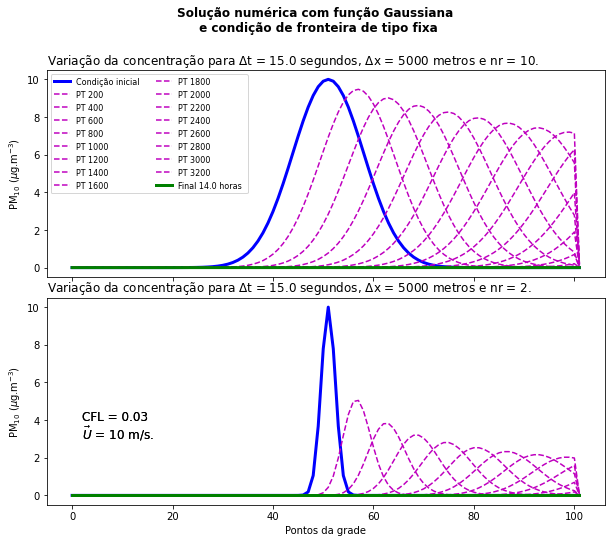

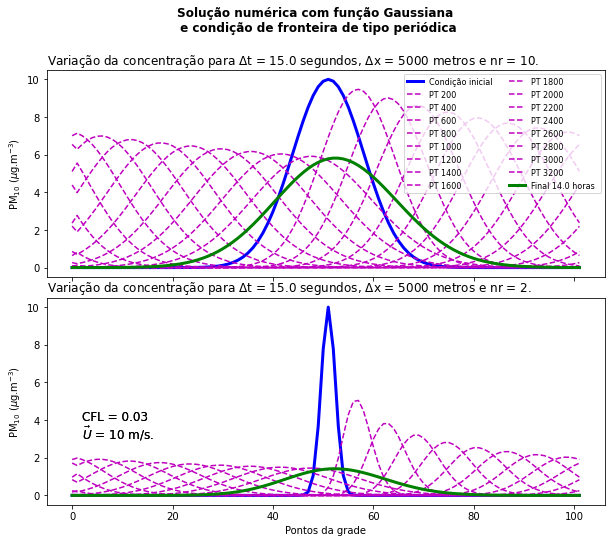

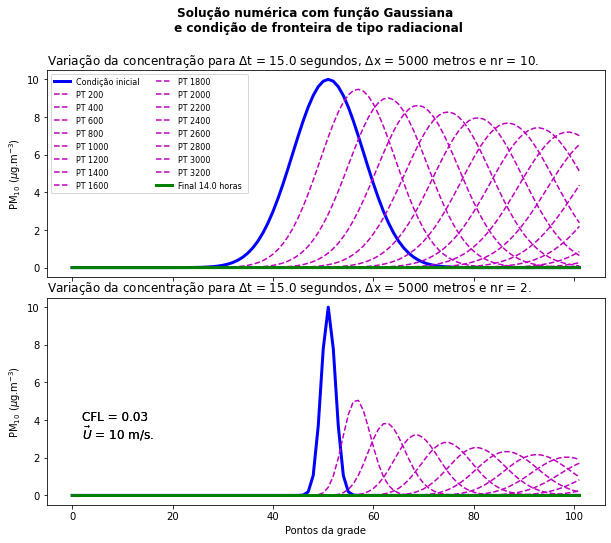

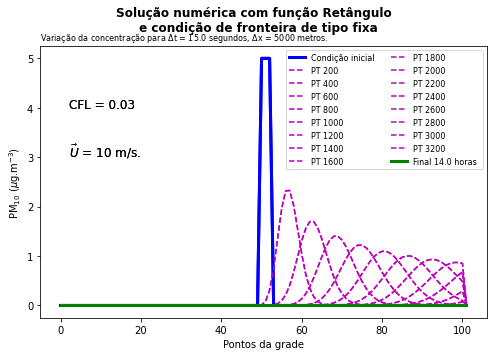

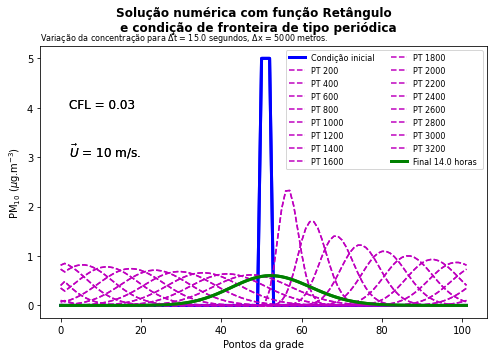

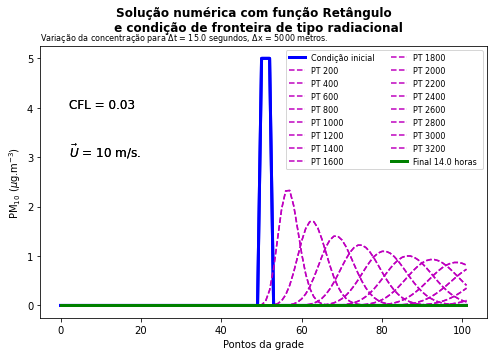

In [38]:
# Aproximação de Ordem 1
for f in ['Gaussiana', 'Retângulo']:
    
    for tipo in ['fixa', 'periódica', 'radiacional']:
        
        sol_num(idx = 51,
                d_passos = 200,
                cond_front = tipo,
                aprox = 'ordem1',
                fun = f, 
                hora = 14, 
                Co = 10, 
                dx = 5000, 
                U_wind = +10,
                CFL_1 = False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


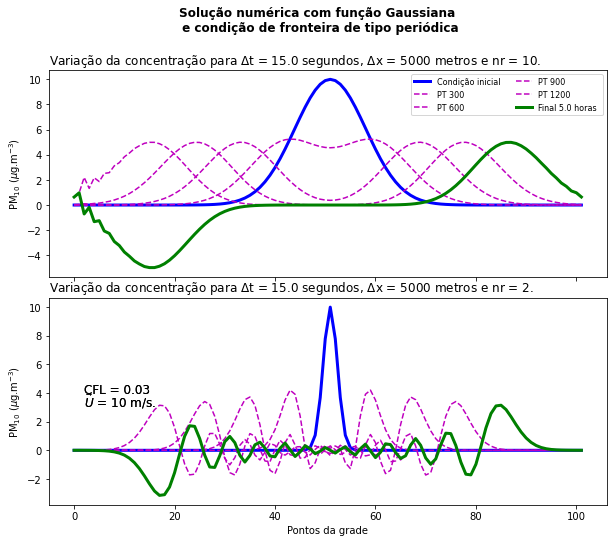

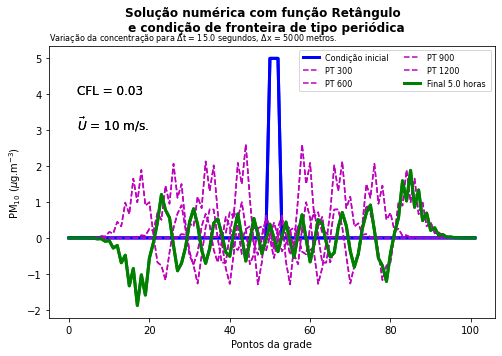

In [40]:
# Aproximação Leap-frog solo periodica:
for f in ['Gaussiana', 'Retângulo']:
    sol_num(idx = 51,
            d_passos = 300,
            cond_front = "periódica",
            aprox = 'leapfrog',
            fun = f, 
            hora = 5, 
            Co = 10, 
            dx = 5000, 
            U_wind = +10,
            CFL_1 = False)

In [5]:
def propagatingFunction(x):
    return np.exp(-np.power(x, 2) / (2. * np.power(np.pi / 4., 2)))

def leapfrog(x, t, v, alpha):

  u = np.zeros((M + 1, N + 1))

  # --- Initial condition
  u[0]      = propagatingFunction(x - v * t[0]) 
  
  # --- First step
  u[1, 1 : N]       = u[0, 1 : N] - 0.5 * alpha * (u[0, 2 : N + 1] - u[0, 0 : N - 1])
  u[1, 0]           = propagatingFunction(x[0] - v * t[1]) 

  Q = (1. - alpha) / (1. + alpha)
  for l in range(1, M):
    u[l + 1, 1 : N]     = u[l - 1, 1 : N] - alpha * (u[l, 2 : N + 1] - u[l, 0 : N - 1]) 
    # --- Boundary condition
    u[l + 1, 0]         = propagatingFunction(x[0] - v * t[l + 1])    
    u[l + 1, N]         = u[l, N - 1] - Q * u[l + 1, N - 1] + Q * u[l, N] 

  return u

xmin  = 0                                    # --- Left boundary of the simulation domain
xmax  = 10. * np.pi                           # --- Right boundary of the simulation domain
t_0   = 0.                                   # --- Initial time
t_f   = 20.                                  # --- Final time
M     = 200                                  # --- Number of time steps
N     = 165                                  # --- Number of space mesh points
v     = 1  

x, dx = np.linspace(xmin, xmax, N + 1, retstep = True)

t, dt = np.linspace(t_0, t_f, M + 1, retstep = True)

alpha = v * dt / dx
X, T = np.meshgrid(x, t)   
uRef = propagatingFunction(X - v * T)
u = leapfrog(x, t, v, alpha)

In [6]:
fig, ax = plt.subplots()
plt.close()

ax.set_xlim(( xmin, xmax))
ax.set_ylim((    0, 1.1))

line1, = ax.plot([], [], lw = 2, color = "r", linestyle = 'dashed')
line2, = ax.plot([], [], lw = 2, color = "b")

def animate(i):
    global x
    global u, uRef
    yRef = uRef[i]
    y    = u[i]
    line1.set_data(x, yRef)
    line2.set_data(x, y)
    return (line1, line2)

anim = animation.FuncAnimation(fig, animate, frames = M + 1, interval = 20)
anim.save('leapfrog.mp4', fps = 30, extra_args=['-vcodec', 'libx264'])
rc('animation', html = 'jshtml') 
anim

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.13.0
  latest version: 4.14.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /Users/adelgado/opt/anaconda3/envs/py39

  added / updated specs:
    - av


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    aom-3.4.0                  |       hbe31e94_1         2.4 MB  conda-forge
    av-9.2.0                   |   py39h109a9f4_2         852 KB  conda-forge
    ca-certificates-2022.6.15  |       h4653dfc_0         149 KB  conda-forge
    certifi-2022.6.15          |     pyhd8ed1ab_1         154 KB  conda-forge
    conda-4.14.0               |   py39h2804cbe_0        1017 KB  conda-forge
    ffmpeg-4.4.2               | gpl_h263e9c8_102         9.2 MB  conda-forge
    gnutls-3.7.7               |       h27a1928_0        